In [ ]:
import image_data_segmentation
import os
import subprocess

import cv2
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from contextlib import nullcontext

import yaml
import torch
import torchvision

from PIL import Image

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.sam2_video_predictor import SAM2VideoPredictor

In [2]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

NameError: name 'np' is not defined

In [3]:
# Device selection
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Optional device-specific settings
if device.type == "cuda":
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

# Load image
image_path = Path("calibration/sensor_1/depth_calibration/sample.png")
if not image_path.exists():
    raise FileNotFoundError(f"Image not found: {image_path}")

image = np.array(Image.open(image_path).convert("RGB"))


plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()



NameError: name 'torch' is not defined

In [4]:
# Load SAM2 model
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Correct file paths
model_cfg = Path("configs/sam2.1/sam2.1_hiera_l.yaml")         # <- this must be a YAML
sam2_checkpoint = Path("../../sam2/sam2.1_hiera_large.pt")  # <- this must be the model .pt file

with torch.autocast("cuda", dtype=torch.bfloat16) if device.type == "cuda" else nullcontext():
    sam2_model = build_sam2(str(model_cfg), str(sam2_checkpoint), device=device)
    predictor = SAM2ImagePredictor(sam2_model)

predictor = SAM2ImagePredictor(sam2_model)

predictor.set_image(image)

NameError: name 'Path' is not defined

In [ ]:
input_point = np.array([[260, 253]])
input_label = np.array([1])

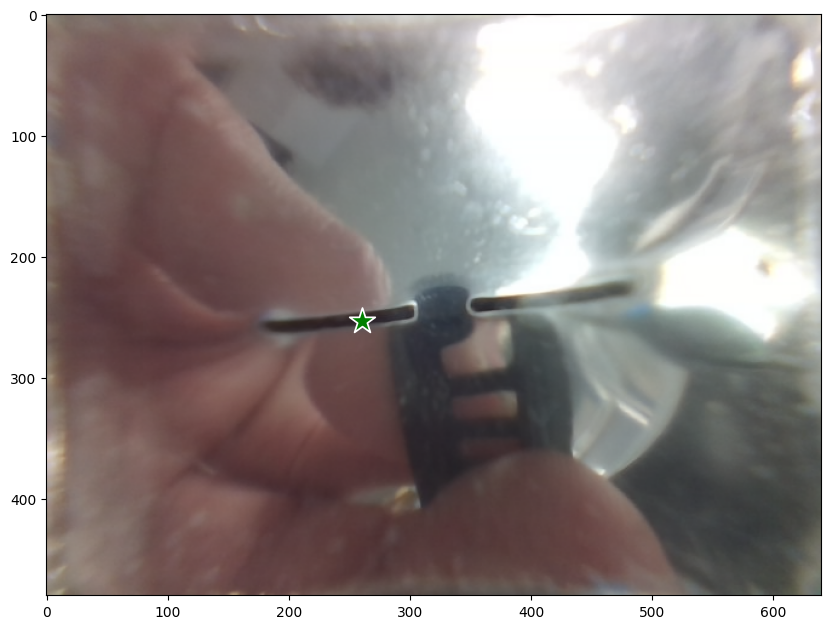

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

In [ ]:
masks.shape  # (number_of_masks) x H x W

(3, 480, 640)

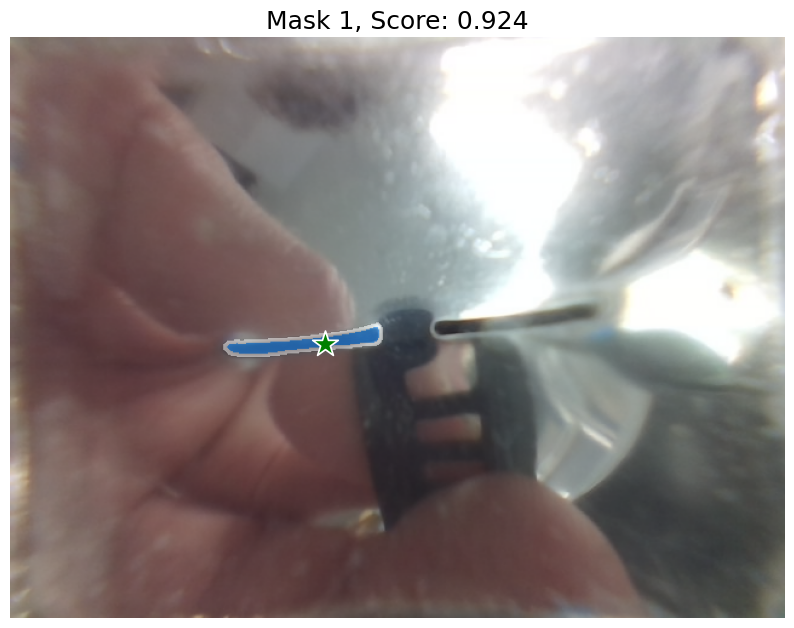

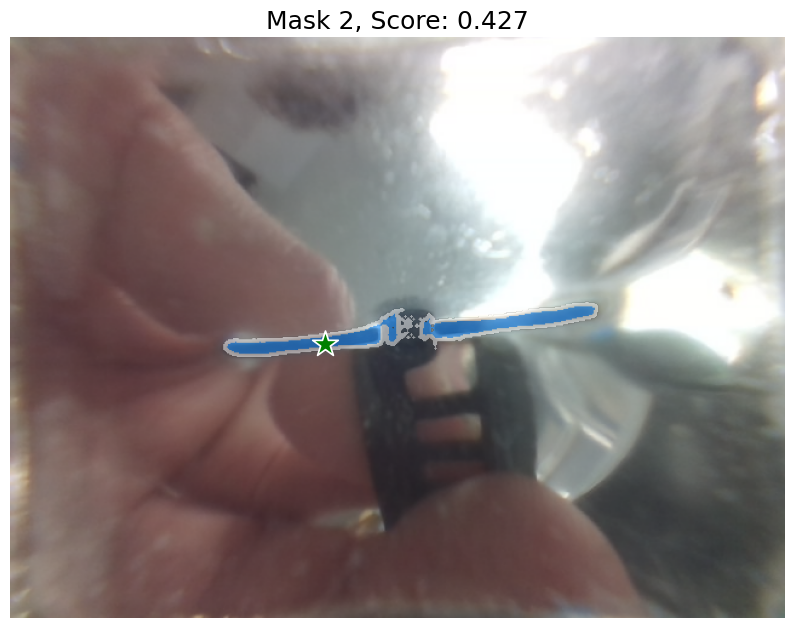

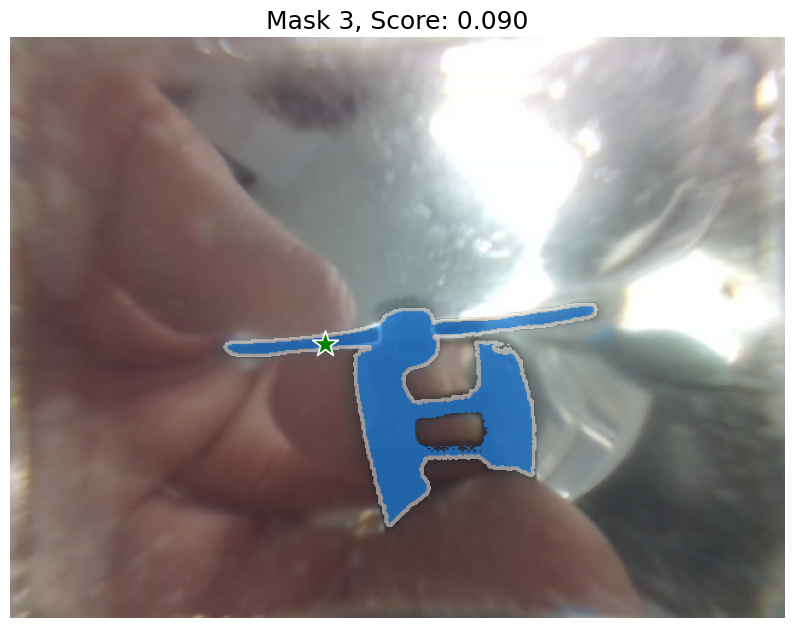

In [ ]:
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

## Video Predictor Set-up

In [ ]:
videos_folder = Path("calibration/sensor_2/depth_calibration/Videos")
video_files = list(videos_folder.glob("*.mp4"))

for video_path in video_files:
    print(f"Processing {video_path}")
    # The following is a typical call, adjust as needed for your API:
    results = video_predictor.predict(video_path)
    # Save or display results as needed

In [ ]:
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")


PyTorch version: 2.7.1+cpu
Torchvision version: 0.22.1+cpu
CUDA is available: False
using device: cpu


In [ ]:
pip install -e ../../sam2

Obtaining file:///C:/Users/ojyca/OneDrive/Documents/SURP%202025/sam2
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for SAM-2 (pyproject.toml): started
  Building editable for SAM-2 (pyproject.toml): finished with status 'done'
  Created wheel for SAM-2: filename=sam_2-1.0-0.editable-py3-none-any.whl size=13945 sha256=bc769a0e0c01c579368f0b3b9c3938363a72fded7f80f44716ede224f79af016
  Stored in directory: C:\Users\ojyca\AppData\Local\Temp\pip-ephem-wheel-cache-60c15q2r\wheels\c5\42\d8\02a64d59244daa97edb94249c2772323bc74c8481b

In [ ]:
from sam2.build_sam import build_sam2_video_predictor

model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"         # <- this must be a YAML
sam2_checkpoint ="../../sam2/sam2.1_hiera_large.pt"  # <- this must be the model .pt file

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [ ]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [ ]:
import os
print(os.path.exists("calibration/sensor_1/depth_calibration/Videos/BluePill_1.mp4"))

False


In [ ]:
video_files = {
    "BluePill_1": "Videos/BluePill_1.mp4",
    "BluePill_2": "Videos/BluePill_2.mp4",
    "BluePill_3": "Videos/BluePill_3.mp4",
    "PCIECover_1": "Videos/PCIECover_1.mp4",
    "PCIECover_2": "Videos/PCIECover_2.mp4",
    "PCIECover_3": "Videos/PCIECover_3.mp4",
    "Screw_1": "Videos/Screw_1.mp4",
    "Screw_2": "Videos/Screw_2.mp4",
    "Staples": "Videos/Staples.mp4",
}

# Output format
output_root = "calibration/frames"

# Create output root if it doesn't exist
os.makedirs(output_root, exist_ok=True)

# Run ffmpeg for each file
for name, video_path in video_files.items():
    # Create output directory for each video
    output_dir = os.path.join(output_root, name)
    os.makedirs(output_dir, exist_ok=True)

    # Output path pattern (e.g., 00000.jpg, 00001.jpg, ...)
    output_pattern = os.path.join(output_dir, "%05d.jpg")

    # FFmpeg command
    cmd = [
        "ffmpeg",
        "-i", video_path,
        "-q:v", "2",              # High-quality JPEG
        "-start_number", "0",
        output_pattern
    ]

    print(f"Extracting frames from {video_path} -> {output_pattern}")
    subprocess.run(cmd, check=True)

print(" All videos converted to frames.")

Extracting frames from Videos/BluePill_1.mp4 -> calibration/frames\BluePill_1\%05d.jpg
Extracting frames from Videos/BluePill_2.mp4 -> calibration/frames\BluePill_2\%05d.jpg
Extracting frames from Videos/BluePill_3.mp4 -> calibration/frames\BluePill_3\%05d.jpg
Extracting frames from Videos/PCIECover_1.mp4 -> calibration/frames\PCIECover_1\%05d.jpg
Extracting frames from Videos/PCIECover_2.mp4 -> calibration/frames\PCIECover_2\%05d.jpg
Extracting frames from Videos/PCIECover_3.mp4 -> calibration/frames\PCIECover_3\%05d.jpg
Extracting frames from Videos/Screw_1.mp4 -> calibration/frames\Screw_1\%05d.jpg
Extracting frames from Videos/Screw_2.mp4 -> calibration/frames\Screw_2\%05d.jpg
Extracting frames from Videos/Staples.mp4 -> calibration/frames\Staples\%05d.jpg
 All videos converted to frames.


In [ ]:

# Load Video
BluePill_1 = "calibration/sensor_1/depth_calibration/Videos/.mp4"
BluePill_2 = "calibration/sensor_2/depth_calibration/Videos/.mp4"
BluePill_3 = "calibration/sensor_3/depth_calibration/Videos/.mp4"
PCIECover_1= "calibration/sensor_4/depth_calibration/Videos/PCIE_Cover_1.mp4"
PCIECover_2= "calibration/sensor_4/depth_calibration/Videos/PCIE_Cover_2.mp4"
PCIECover_3= "calibration/sensor_4/depth_calibration/Videos/PCIE_Cover_3.mp4"
Screw_1= "calibration/sensor_4/depth_calibration/Videos/Screw_1.mp4"
Screw_2= "calibration/sensor_4/depth_calibration/Videos/Screw_2.mp4"
Staples = "calibration/sensor_4/depth_calibration/Videos/Staples.mp4"



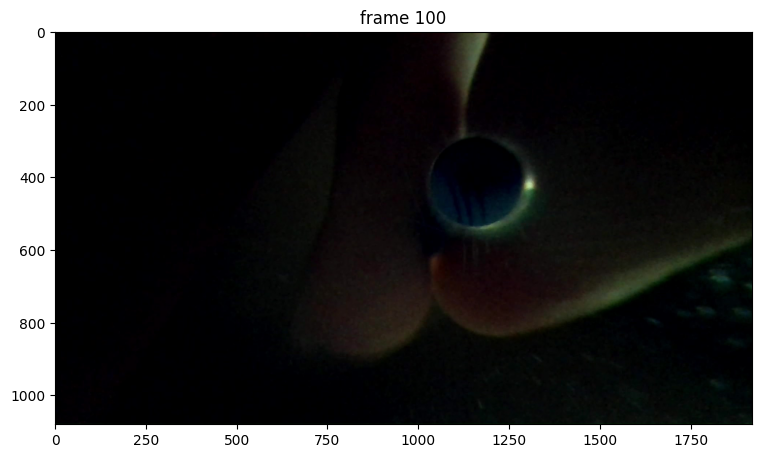

In [ ]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dirs = {
    "BluePill_1": "./calibration/frames/BluePill_1",
    "BluePill_2": "./calibration/frames/BluePill_2",
    "BluePill_3": "./calibration/frames/BluePill_3",
    "PCIECover_1": "./calibration/frames/PCIECover_1",
    "PCIECover_2": "./calibration/frames/PCIECover_2",
    "PCIECover_3": "./calibration/frames/PCIECover_3",
    "Screw_1": "./calibration/frames/Screw_1",
    "Screw_2": "./calibration/frames/Screw_2",
    "Staples": "./calibration/frames/Staples",
}

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dirs["BluePill_1"])
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 100
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dirs["BluePill_1"], frame_names[frame_idx])))

In [ ]:
calibration_sample = Path("calibration/images/calibration_sample.png")




In [ ]:
# --- IGNORE ---
# Step 1: identify objects throughout the full video
# Step 2: identify key frames while object is in contact with gel film
#   - Frame in which the object is in contact with gel film
#   - Frame in which object is at peak depth
# Step 3: Process the key frames to extract masks
# Step 4: Save the masks and key frames for further processing
# Step 5: Generate 3D point cloud from the masks and key frames and model the object
# Compare generated 3D model with the original object, save results for further analysis
#  
# Step 6: Repeat Step 1-5 for all objects in the video
# --- IGNORE ---

### Step 1: Identify objects throughout the full video
- Goal: For each frame in the video, use an automatic mask generator (e.g., SAM2 or similar) to segment all objects.
- Reference: Use the automatic mask generator code from ```~sam2/notebooks/automatic_mask_generator_example.ipynb.```

- Implementation:
    - Load the video and iterate through each frame.
    - For each frame, run the mask generator to get object masks.
    - Optionally, filter masks by size, shape, or location if you have prior knowledge about the object of interest.

In [ ]:
# ---- 2. Load model config and checkpoint ----
model_cfg = "sam2/configs/sam2.1/sam2.1_hiera_l.yaml"  # adjust path as needed
sam2_checkpoint = "sam2/checkpoints/sam2.1_hiera_large.pt"  # adjust path as needed

# ---- 3. Build the SAM2 model ----
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

# ---- 4. Create the automatic mask generator ----
mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

# ---- 5. Open the video ----
video_path = "path/to/your/video.mp4"
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise ValueError("Could not open video file")

frame_idx = 0
all_masks = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to RGB if needed (OpenCV loads as BGR)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # ---- 6. Generate masks for this frame ----
    masks = mask_generator.generate(frame_rgb)
    all_masks.append(masks)

    # (Optional) Save or process masks here, e.g. filter by area, save to disk, etc.
    print(f"Frame {frame_idx}: {len(masks)} masks found")
    frame_idx += 1

cap.release()

### Step 1b.

### Step 2: identify key frames while object is in contact with gel film
- Goal: Find frames where the object is in contact with the gel film and at peak depth.

- Implementation:
    - Analyze the sequence of masks to detect when the object first touches the gel (e.g., by proximity to a reference area or sudden appearance).
    - Detect the frame with the largest mask area or maximum penetration (peak depth).
    - Save the indices of these key frames.

In [ ]:
contact_frame_idx = None
peak_depth_frame_idx = None
max_area = 0

for idx, masks in enumerate(all_masks):
    if not masks:
        continue
    # Find the largest mask in this frame
    largest_mask = max(masks, key=lambda m: m['area'])
    area = largest_mask['area']

    # Contact frame: first frame with a sufficiently large mask (tune threshold as needed)
    if contact_frame_idx is None and area > 500:  # 500 is an example threshold
        contact_frame_idx = idx

    # Peak depth: frame with the largest mask area
    if area > max_area:
        max_area = area
        peak_depth_frame_idx = idx

print(f"Contact frame index: {contact_frame_idx}")
print(f"Peak depth frame index: {peak_depth_frame_idx}")

### Step 3: Process the key frames to extract masks
- Goal: For the key frames identified, extract and refine the object masks.

- Implementation:
    - For each key frame, run the mask generator again (if needed) to get a high-quality mask.
    - Optionally, post-process the mask (e.g., morphological operations, filtering).

In [ ]:
# Assuming you have a list of frames (from your video reading loop)
# If not, you can re-read the video to get the key frames

def get_frame_at_index(video_path, idx):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise ValueError(f"Could not read frame at index {idx}")
    return frame

# Get key frames
contact_frame = get_frame_at_index(video_path, contact_frame_idx)
peak_depth_frame = get_frame_at_index(video_path, peak_depth_frame_idx)

# Get corresponding masks
contact_mask_dict = max(all_masks[contact_frame_idx], key=lambda m: m['area'])
peak_depth_mask_dict = max(all_masks[peak_depth_frame_idx], key=lambda m: m['area'])

contact_mask = contact_mask_dict['segmentation']
peak_depth_mask = peak_depth_mask_dict['segmentation']

# (Optional) Save masks and frames for later use
import imageio

imageio.imwrite("contact_frame.png", cv2.cvtColor(contact_frame, cv2.COLOR_BGR2RGB))
imageio.imwrite("peak_depth_frame.png", cv2.cvtColor(peak_depth_frame, cv2.COLOR_BGR2RGB))
imageio.imwrite("contact_mask.png", (contact_mask * 255).astype(np.uint8))
imageio.imwrite("peak_depth_mask.png", (peak_depth_mask * 255).astype(np.uint8))

### Step 4: Save the masks and key frames for further processing

- Goal: Store the masks and corresponding frames for later use.

- Implementation:
    - Save the key frame images (e.g., as PNG/JPG).
    - Save the masks (e.g., as PNG, NumPy arrays, or binary masks).

### Step 5: Generate 3D point cloud from the masks and key frames and model the object
- Goal: Use the masks and key frames to reconstruct a 3D model of the object.

- Implementation:
    - Use the mask sequence and known camera parameters to triangulate or estimate depth.
    - Generate a point cloud (e.g., using OpenCV, PCL, or custom code).
Fit a 3D model to the point cloud if needed.

Compare generated 3D model with the original object, save results for further analysis

### Step 6: Repeat Step 1-5 for all objects in the video
- Goal: Apply the above steps to all objects of interest in the video.
- Implementation:
    - Loop through all detected objects or all relevant video segments.
    - Optionally, parallelize or batch process for efficiency.